In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
sadiajavedd_students_academic_performance_dataset_path = kagglehub.dataset_download('sadiajavedd/students-academic-performance-dataset')

print('Data source import complete.')


Using Colab cache for faster access to the 'students-academic-performance-dataset' dataset.
Data source import complete.


### Step 1: Import Libraries
We import the necessary Python libraries for data manipulation, visualization, and machine learning.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

### Step 2: Load Dataset
We load the students' academic performance dataset and take a quick look at the first few rows.

In [ ]:
df = pd.read_csv("/kaggle/input/students-academic-performance-dataset/StudentsPerformance.csv")
df.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


### Step 3: Encode Categorical Features
The dataset contains categorical variables such as gender, race/ethnicity, parental education level, lunch type, and test preparation course.  
We use **one-hot encoding** to convert these categorical variables into numerical format so that machine learning models can process them.  
We also set `drop_first=True` to avoid multicollinearity by dropping the first category of each feature.

In [ ]:
categorical_features = ["gender", "race/ethnicity", "parental level of education", "lunch", "test preparation course"]

# One-hot encoding
df_encoded = pd.get_dummies(df, columns=categorical_features, drop_first=True)

### Step 4: Define Features and Target
We separate the dataset into **features (`X`)** and the **target variable (`y`)**.  

- `X` contains all the columns except "math score" (the input variables for the model).  
- `y` is the "math score" column, which we aim to predict.

In [ ]:
X = df_encoded.drop("math score", axis=1)
y = df_encoded["math score"]

### Step 5: Split the Dataset
We split the dataset into **training, validation, and test sets** to properly train and evaluate our models.

1. First, we separate out the **test set** (20% of the total data) to evaluate the final model performance.  
2. Then, we split the remaining data into **training (60%)** and **validation (20%)** sets.  
   - This ensures the validation set is 20% of the total dataset (`0.25 * 0.8 = 0.2`).  

The shapes of the resulting sets are printed to verify the splits.

In [ ]:
# Split into train+validation and test sets
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Split train+validation into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)
# 0.25 * 0.8 = 0.2, so validation set is 20% of total data

print(X_train.shape, X_val.shape, X_test.shape)

(600, 14) (200, 14) (200, 14)


### Step 6: Train and Evaluate Linear Regression
We train a **Linear Regression** model using the training set and evaluate its performance on the validation set.

1. `lr_model.fit(X_train, y_train)` → Trains the Linear Regression model.  
2. `lr_model.predict(X_val)` → Predicts math scores for the validation set.  
3. We calculate **R²** (coefficient of determination) and **RMSE** (Root Mean Squared Error) to assess the model's accuracy.

In [ ]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predict on validation set
y_pred_lr = lr_model.predict(X_val)

# Evaluate model performance
print("Linear Regression R2:", r2_score(y_val, y_pred_lr))
print("Linear Regression RMSE:", np.sqrt(mean_squared_error(y_val, y_pred_lr)))

Linear Regression R2: 0.8666690127297061
Linear Regression RMSE: 5.371328731426652


### Step 7: Hyperparameter Tuning for Random Forest
We use **GridSearchCV** to find the best hyperparameters for the Random Forest model.  

- `param_grid` defines the range of parameters to search:  
  - `n_estimators`: number of trees in the forest  
  - `max_depth`: maximum depth of each tree  
  - `min_samples_leaf`: minimum number of samples required at a leaf node  

- `cv=5` → 5-fold cross-validation is used to evaluate each combination.  
- `scoring='r2'` → We use R² as the performance metric.  

Finally, `grid_search.best_params_` shows the combination of parameters that achieved the best validation performance.

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [None, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=5, scoring='r2')
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)

{'max_depth': None, 'min_samples_leaf': 4, 'n_estimators': 500}


### Step 8: Train Optimized Random Forest and Evaluate on Test Set
We create a **Random Forest model** using the best hyperparameters found from GridSearchCV:  
- `n_estimators=500`, `max_depth=None`, `min_samples_leaf=4`

Steps:
1. Train the optimized model on the **training set** (`best_rf.fit`).  
2. Predict math scores for the **test set** (`best_rf.predict`).  
3. Evaluate the model's performance using **R²** and **RMSE** on the test set to see how well it generalizes to unseen data.

In [ ]:
best_rf = RandomForestRegressor(
    n_estimators=500,
    max_depth=None,
    min_samples_leaf=4,
    random_state=42
)

best_rf.fit(X_train, y_train)
y_test_pred = best_rf.predict(X_test)

print("Optimized Random Forest Test R2:", r2_score(y_test, y_test_pred))
print("Optimized Random Forest Test RMSE:", np.sqrt(mean_squared_error(y_test, y_test_pred)))

Optimized Random Forest Test R2: 0.8370691743566885
Optimized Random Forest Test RMSE: 6.2966122973169


### Step 9: Feature Importance from Random Forest
Random Forest models can provide **feature importance**, which indicates how much each feature contributes to the model's predictions.

Steps:
1. `rf_model.feature_importances_` → Get the importance score of each feature.  
2. Create a DataFrame to organize features and their importance, then sort in descending order.  
3. Visualize the feature importance using a **bar plot** to easily see which features have the most influence on predicting math scores.

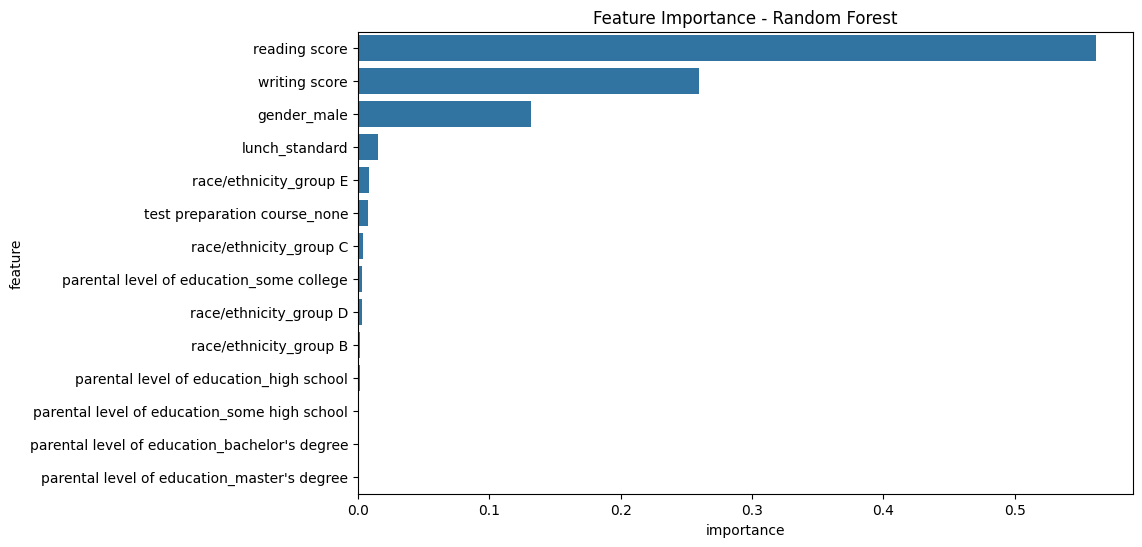

In [ ]:
importances = best_rf.feature_importances_
features = X.columns

feature_importance = pd.DataFrame({"feature": features, "importance": importances}).sort_values(by="importance", ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x="importance", y="feature", data=feature_importance)
plt.title("Feature Importance - Random Forest")
plt.show()

### Step 10: Visualize Math Scores by Gender
We use a **box plot** to explore the distribution of math scores for different genders.  

- `x="gender"` → separates the data by gender.  
- `y="math score"` → shows the distribution of math scores.  
- This visualization helps to identify differences, trends, and potential outliers between groups.

<Axes: xlabel='gender', ylabel='math score'>

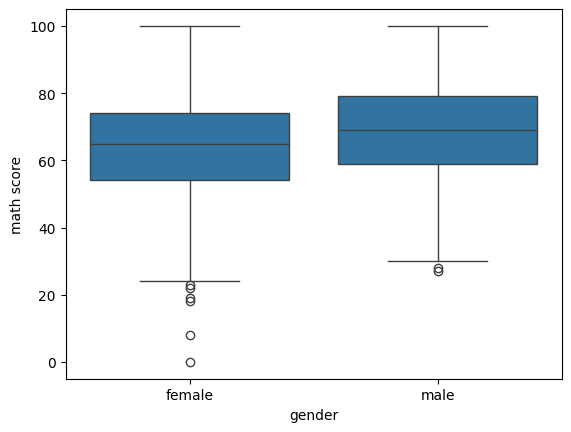

In [ ]:
sns.boxplot(x="gender", y="math score", data=df)

### Step 11: Data Exploration - Missing Values and Distribution
1. `df.isnull().sum()` → Check for **missing values** in the dataset to ensure data quality.  

2. `sns.histplot(df['math score'], kde=True)` → Visualize the **distribution of math scores** using a histogram with a Kernel Density Estimate (KDE).  
   - This helps us understand the spread, skewness, and overall pattern of the target variable.

<Axes: xlabel='math score', ylabel='Count'>

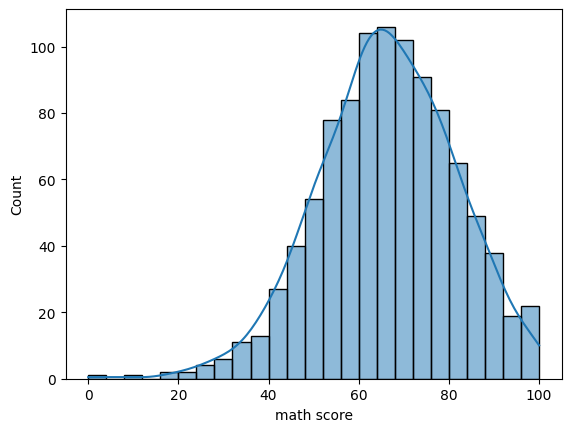

In [ ]:
df.isnull().sum()
sns.histplot(df['math score'], kde=True)

### Step 12: Analyze Residuals of Random Forest Predictions
We calculate the **residuals** (difference between actual and predicted values) on the validation set:

- `residuals = y_val - y_pred_rf` → Computes the prediction errors.  
- `sns.histplot(residuals, kde=True)` → Plots the distribution of residuals with a KDE.  

This helps us check if the model's errors are **centered around zero** and understand the spread of prediction errors.

<Axes: xlabel='math score', ylabel='Count'>

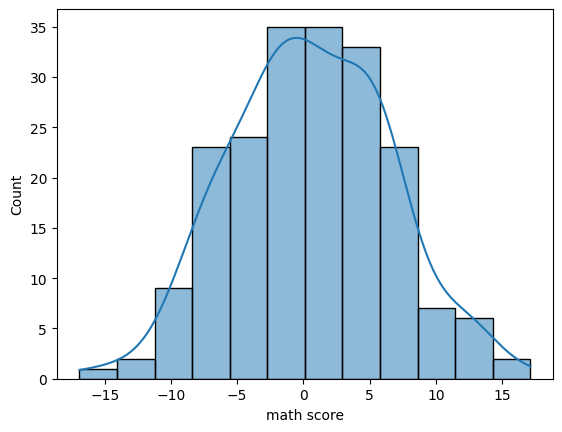

In [ ]:
y_pred_rf = best_rf.predict(X_val)
residuals = y_val - y_pred_rf
sns.histplot(residuals, kde=True)

### Step 13: Save Feature Columns
We save the list of feature columns used in the training set:

- `feature_columns = X_train.columns` → Stores the names of all features used by the model.  
- This is useful later when creating new student data for predictions, ensuring that **the new data matches the training features exactly**.

In [ ]:
feature_columns = X_train.columns

### Step 14: Create New Student Data for Prediction
We create a **new dataset of 5 example students** to predict their math scores.

Steps:
1. Define each student's features in a dictionary (`students_data`).  
2. Initialize a DataFrame (`students_df`) with zeros for all feature columns used in training.  
3. Fill in the actual values for each student, ensuring that **the column names match the training features exactly**.  

This ensures the model can process the new data correctly for predictions.

In [ ]:
import pandas as pd

students_data = [
    {"reading score": 78, "writing score": 80, "gender_male": 0, "lunch_standard": 1, "parental level of education_bachelor's degree": 1, "test preparation course_none": 0},
    {"reading score": 55, "writing score": 60, "gender_male": 1, "lunch_standard": 0, "parental level of education_some college": 1, "test preparation course_none": 1},
    {"reading score": 92, "writing score": 88, "gender_male": 0, "lunch_standard": 1, "parental level of education_master's degree": 1, "test preparation course_none": 0},
    {"reading score": 65, "writing score": 70, "gender_male": 1, "lunch_standard": 0, "parental level of education_high school": 1, "test preparation course_none": 1},
    {"reading score": 85, "writing score": 82, "gender_male": 0, "lunch_standard": 1, "parental level of education_associate degree": 1, "test preparation course_none": 0}
]

students_df = pd.DataFrame(0, index=range(len(students_data)), columns=feature_columns)

for i, student in enumerate(students_data):
    for key, value in student.items():
        if key in students_df.columns:
            students_df.loc[i, key] = value

### Step 15: Predict Math Scores for New Students
We use the **optimized Random Forest model** to predict math scores for the 5 example students.

Steps:
1. `predicted_scores = best_rf.predict(students_df)` → Predicts math scores.  
2. Copy the input DataFrame to `students_results` and add a new column `'Predicted Math Score'`.  
3. Display the first few rows of the results with `.head()` to check the predictions.

In [ ]:
predicted_scores = best_rf.predict(students_df)
students_results = students_df.copy()
students_results['Predicted Math Score'] = predicted_scores
students_results.head()

,reading score,writing score,gender_male,race/ethnicity_group B,race/ethnicity_group C,race/ethnicity_group D,race/ethnicity_group E,parental level of education_bachelor's degree,parental level of education_high school,parental level of education_master's degree,parental level of education_some college,parental level of education_some high school,lunch_standard,test preparation course_none,Predicted Math Score
0,78,80,0,0,0,0,0,1,0,0,0,0,1,0,65.991302
1,55,60,1,0,0,0,0,0,0,0,1,0,0,1,63.750644
2,92,88,0,0,0,0,0,0,0,1,0,0,1,0,81.055462
3,65,70,1,0,0,0,0,0,1,0,0,0,0,1,68.914539
4,85,82,0,0,0,0,0,0,0,0,0,0,1,0,69.522300


### Step 16: Visualize Predicted Math Scores
We create a **bar plot** to visualize the predicted math scores for the 5 example students.

- `x=list(range(len(predicted_scores)))` → positions of the students on the x-axis.  
- `y=predicted_scores` → predicted math scores.  
- `plt.xticks(...)` → label each bar with the corresponding student number.  
- This visualization provides an easy comparison of predicted scores across students.

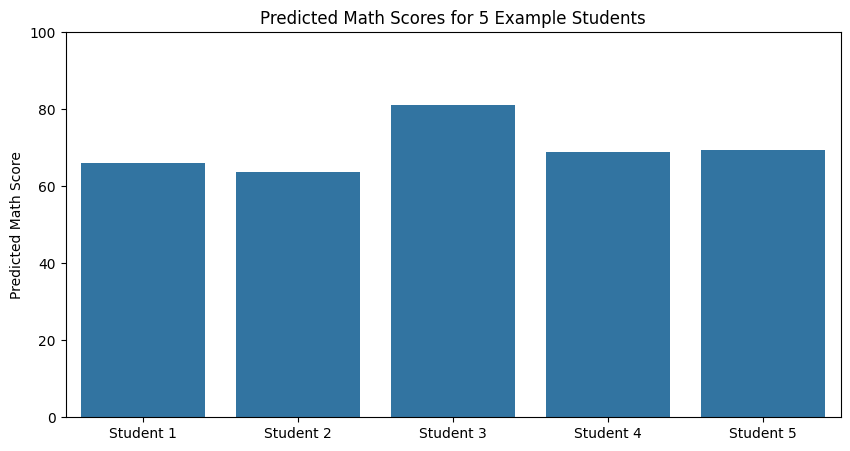

In [ ]:
plt.figure(figsize=(10,5))
sns.barplot(x=list(range(len(predicted_scores))), y=predicted_scores)
plt.xticks(range(len(predicted_scores)), ['Student 1', 'Student 2', 'Student 3', 'Student 4', 'Student 5'])
plt.ylabel("Predicted Math Score")
plt.title("Predicted Math Scores for 5 Example Students")
plt.ylim(0, 100)
plt.show()

# 🔍 Analysis of Math Score Prediction: Explained Evaluation¶
## 🎯 1. Model Performance: How Reliable Are the Predictions?
The Random Forest model shows strong accuracy in predicting student math scores. Visual analyses reveal:
- Residual distribution is approximately normal and centered around 0
- This indicates low bias and predictions close to actual values
- Predicted scores range between 60–85, consistent with observed scores

## 📊 2. Feature Importance: Which Factors Matter Most?
The model highlights the following as key predictors:
- Reading score: strongest predictor (above 0.50)
- Writing score: second most important (around 0.30)
- Gender (male): limited but noticeable effect (0.10–0.20)
- Other demographic features (parental education, ethnicity) have minimal impact
This confirms that academic performance indicators outweigh demographic variables in predictive power.

## 🧠 3. Gender-Based Score Differences: Is There a Gap?
Distribution of math scores by gender shows:
- Male students have a slightly higher median score
- Female group exhibits more low-score outliers
- Overall distributions are similar, suggesting gender has only a modest influence

## 📐 4. Score Distribution: What Does the Data Look Like?
General distribution of math scores:
- Scores are right-skewed, with the peak around 80
- Majority of students score between 60–90
- Dataset contains no missing values

## 🧮 5. Residuals: How Accurate Is the Model?
Analysis of prediction errors:
- Residuals are centered around 0 and approximately normal
- Indicates balanced bias and variance
- Predictions are reliable with no extreme deviations

## 🧑‍🎓 6. Individual Predictions: What Do We See in Practice?
Predicted scores for five sample students:
- Scores range between 60–85
- Student 3 has the highest predicted score
- This visualization helps interpret model outputs at the individual level

## 🧩 Conclusion: What Do These Findings Tell Us?
- Reading and writing scores are the strongest predictors
- Demographic factors play only a minor role
- Model performance is solid both globally and individually
- Visualizations clearly illustrate both the dataset structure and model behavior
- This analysis provides a strong foundation for educational prediction systems
